In [4]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
import multiprocessing
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2/home/dli36/interbankSystem/defaultSimulation1
%pylab inline 
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['font.size'] = 25

Populating the interactive namespace from numpy and matplotlib


In [8]:
import numpy as np
import pandas as pd
label = ["baseModel", "highReserve", "highLeverage","lowBorrow", "noBorrow","lowCorrelation", "noCorrelation","301", "302",]
label = ["baseModel","lowCorrelation", "noCorrelation"]

defaultCollection = np.concatenate([np.load("defaultSimulation/defaultCollection_" + l + ".npy") for l in label],axis=0)
defaultBanks = np.concatenate([np.load("defaultSimulation/defaultBanks_" + l + ".npy") for l in label],axis=0)

In [12]:
defaultBanks.shape

(3, 2000, 100)

In [28]:
summaryDF = pd.DataFrame(columns=label, data = defaultCollection.T).describe().round(2)
PrintLabel = ["Base Model", "High Reserve", "High Leverage","Low Borrow", "No Borrow","Low Correlation", "No Correlation","2 Shock", "1 Shock"]
summaryDF.columns = PrintLabel
print(summaryDF.iloc[:,:5].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Base Model &  High Reserve &  High Leverage &  Low Borrow &  No Borrow \\
\midrule
count &     2000.00 &       2000.00 &        2000.00 &     2000.00 &    2000.00 \\
mean  &       12.03 &          9.29 &          14.59 &        7.02 &       3.55 \\
std   &       20.01 &         16.90 &          22.56 &       16.64 &      13.55 \\
min   &        0.00 &          0.00 &           0.00 &        0.00 &       0.00 \\
25\%   &        0.00 &          0.00 &           0.00 &        0.00 &       0.00 \\
50\%   &        2.00 &          1.00 &           3.00 &        0.00 &       0.00 \\
75\%   &       14.00 &         10.00 &          20.00 &        4.00 &       0.00 \\
max   &      100.00 &         90.00 &         100.00 &       97.00 &     100.00 \\
\bottomrule
\end{tabular}



In [29]:
print(summaryDF.iloc[:,[0,5,6,7,8,]].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Base Model &  Low Correlation &  No Correlation &  2 Shock &  1 Shock \\
\midrule
count &     2000.00 &          2000.00 &         2000.00 &  2000.00 &  2000.00 \\
mean  &       12.03 &            11.79 &           11.73 &     1.68 &     0.08 \\
std   &       20.01 &            15.41 &            3.20 &     7.98 &     1.51 \\
min   &        0.00 &             0.00 &            3.00 &     0.00 &     0.00 \\
25\%   &        0.00 &             2.00 &            9.00 &     0.00 &     0.00 \\
50\%   &        2.00 &             5.00 &           12.00 &     0.00 &     0.00 \\
75\%   &       14.00 &            16.00 &           14.00 &     0.00 &     0.00 \\
max   &      100.00 &            88.00 &           22.00 &    99.00 &    55.00 \\
\bottomrule
\end{tabular}



In [13]:
pylab.rcParams['figure.figsize'] = (20, 5)
def plotDefaultBanks(defaultBanks, cats, labels):
    fig, axs = plt.subplots(1, 2)
    # Defining custom 'xlim' and 'ylim' values.
    custom_xlim = (-5, 105)
    custom_ylim = (0, 0.3)
    # Setting the values for all axes.
    plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
    #fig.suptitle('Number of Defaults over 100 Banks(From the laregest to the smallest)')
    axs[0].bar(range(100), defaultBanks[0].sum(axis=0)/2000., label = "Base Model",alpha=0.5)
    axs[0].bar(range(100), defaultBanks[cats[0]].sum(axis=0)/2000., label = labels[0],alpha=0.5)
    axs[0].set_xlabel("Bank ID")
    axs[0].set_ylabel("Probalility of Defaults")
    axs[0].legend()
    axs[1].bar(range(100), defaultBanks[0].sum(axis=0)/2000., label = "Base Model",alpha=0.5)
    axs[1].bar(range(100), defaultBanks[cats[1]].sum(axis=0)/2000., label = labels[1],alpha=0.5)
    axs[1].set_xlabel("Bank ID")
    #axs[1].set_ylabel("Probalility of Defaults")
    axs[1].legend()

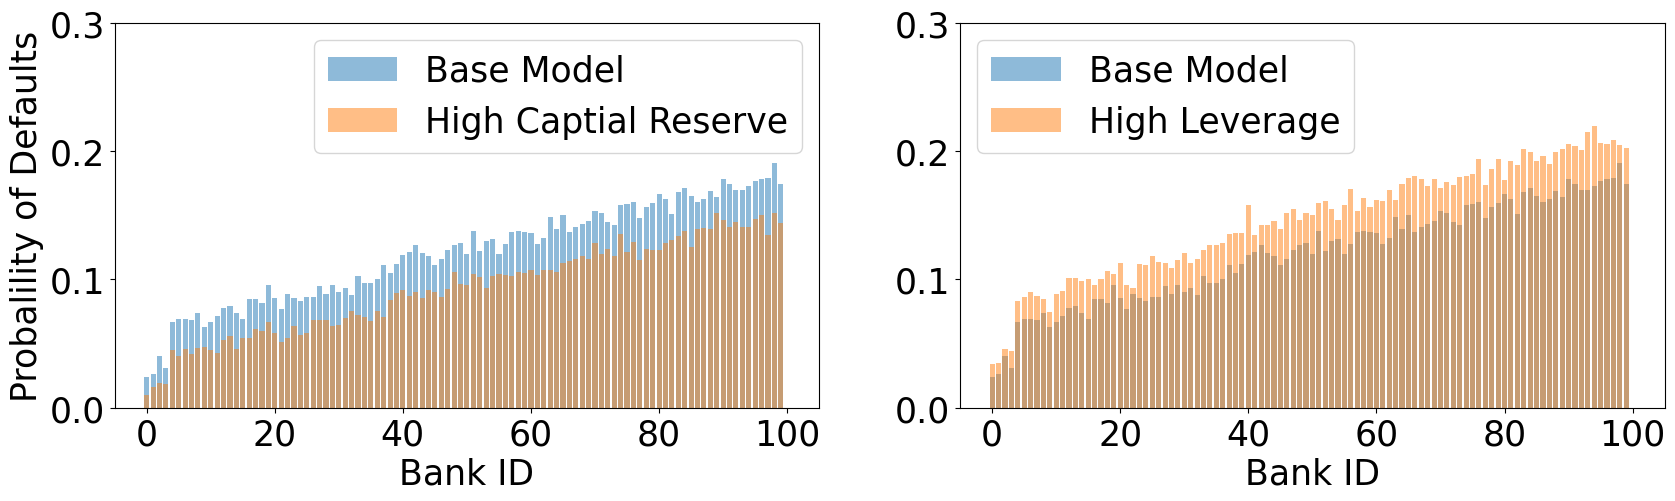

In [31]:
plotDefaultBanks(defaultBanks, [1,2], ["High Captial Reserve", "High Leverage"])

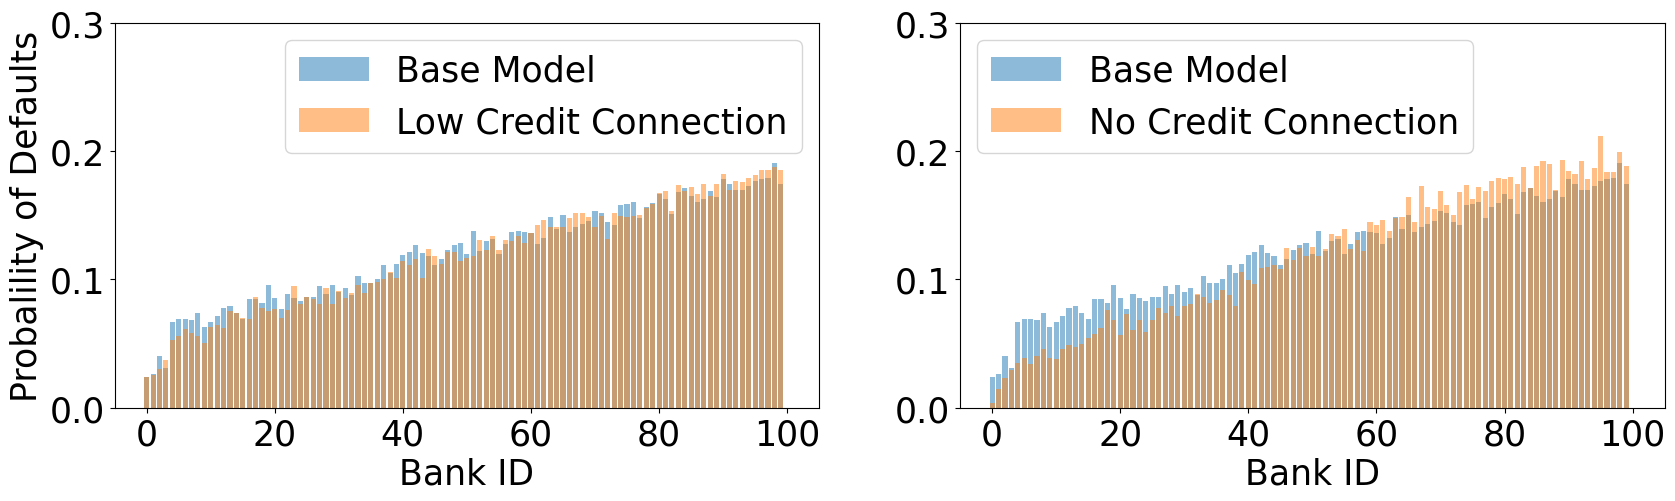

In [15]:
plotDefaultBanks(defaultBanks, [3,4], ["Low Credit Connection", "No Credit Connection"])

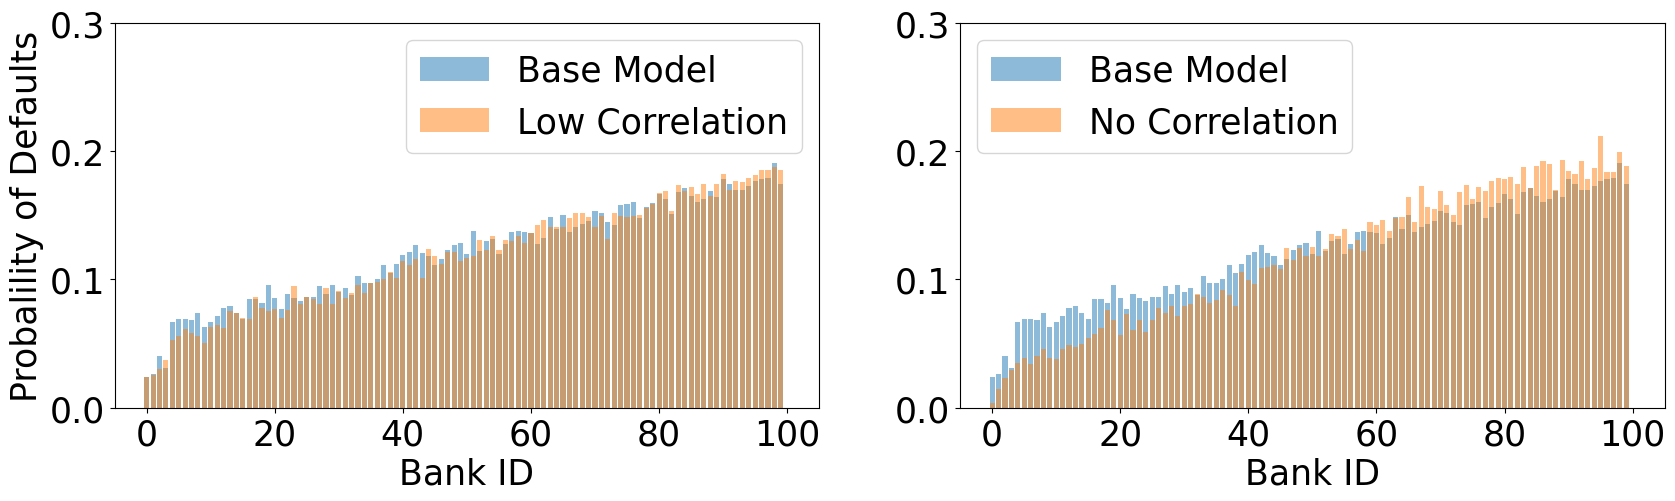

In [16]:
plotDefaultBanks(defaultBanks, [1,2], ["Low Correlation", "No Correlation"])

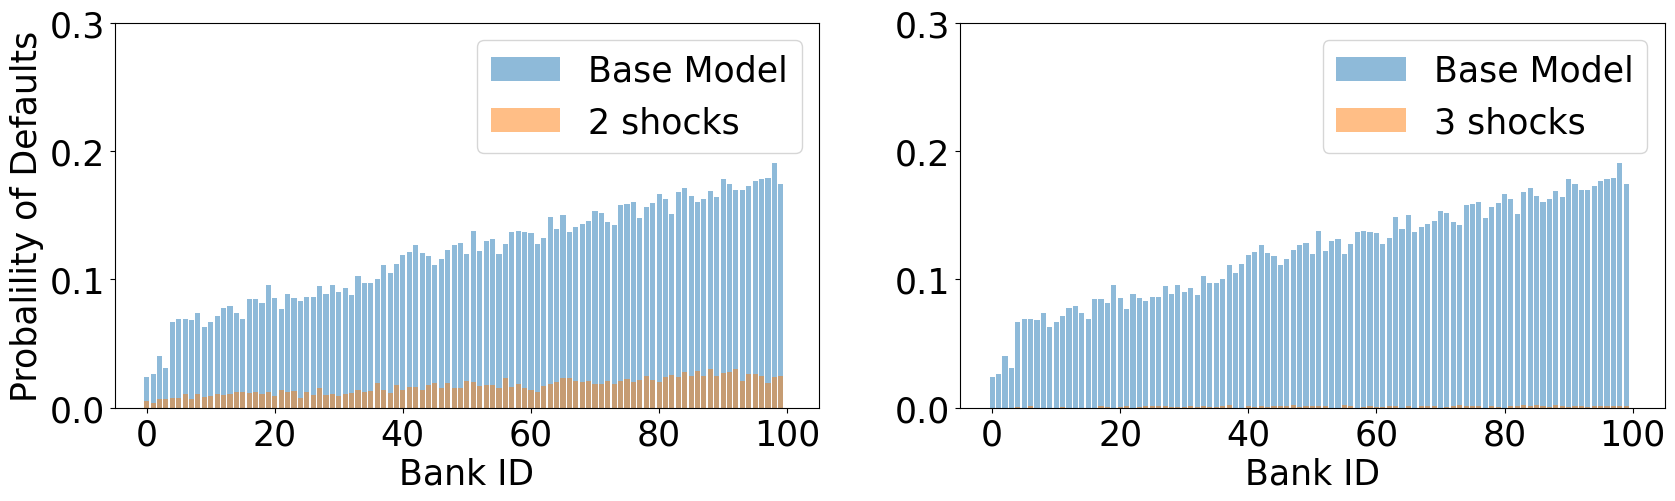

In [34]:
plotDefaultBanks(defaultBanks, [7,8], ["2 shocks", "3 shocks"])

In [35]:
# portfolio return volatility
def R(cor,shockSize):
    returnVolatiliy = 0.18/np.sqrt(252)
    # return correlation matrix
    cMatrix = np.ones((100,100))*cor
    np.fill_diagonal(cMatrix, 1)
    Cholesky = np.linalg.cholesky(cMatrix * returnVolatiliy**2)
    r = np.abs(shockSize * Cholesky @ np.random.randn(100,1))
    return r

Rs = np.array([R(0.8,5).flatten() for _ in range(2000)])
Rs.shape


(2000, 100)

In [36]:
for cor in [0.9, 0.7, 0.6,0]:
    Rs = np.array([R(cor,10).flatten() for _ in range(2000)])
    print(np.corrcoef(Rs.T).mean(), np.corrcoef(Rs.T).std(), Rs.mean(axis = 0).mean(), Rs.mean(axis=0).std())

0.7776092118961897 0.023675783299512743 0.09118177471579925 0.0007393287176603442
0.44023627609540883 0.058852268411513003 0.08860849941504148 0.0011072746403882074
0.3328661317652136 0.07012021584209728 0.09023661847861812 0.0012301048020692186
0.009813112521564731 0.10202782713360935 0.09069480707525118 0.001501882254484611
